In [9]:
%reload_kedro
train = catalog.load("train_data")
eval_data = catalog.load("eval_data")
prepared_data = catalog.load("prepared_data")
test = catalog.load("test_data")
seg_metrics = catalog.load("seg_metrics")

2022-02-13 02:23:13,379 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.7.6
2022-02-13 02:23:13,479 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-02-13 02:23:13,572 - kedro.config.config - INFO - Config from path `/home/matheus/projects/time_series_kedro/conf/local` will override the following existing top-level config keys: fr_horizon, initial, n_jobs, sampling
2022-02-13 02:23:13,574 - root - INFO - ** Kedro project time_series_kedro
2022-02-13 02:23:13,575 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-13 02:23:13,593 - root - INFO - Registered line magic `run_viz`
2022-02-13 02:23:13,594 - root - INFO - Registered line magic `reload_kedro_mlflow`
2022-02-13 02:23:13,595 - kedro.io.data_catalog - INFO - Loading data from `train_data` (CSVDataSet)...


/home/matheus/.local/lib/python3.8/site-packages/kedro/io/core.py:151: DeprecatedWarning: __init__ is deprecated as of 0.7.3 and will be removed in 0.8.0. Deprecated in favor of 'MlflowMetricDataSet' (for a single metric) or 'MlflowMetricHistoryDataSet '(for the metric evolution over time)
  data_set = class_obj(**config)  # type: ignore
/home/matheus/.local/lib/python3.8/site-packages/kedro_mlflow/framework/hooks/pipeline_hook.py:53: DeprecatedWarning: __init__ is deprecated as of 0.7.3 and will be removed in 0.8.0. Deprecated in favor of 'MlflowMetricDataSet' (for a single metric) or 'MlflowMetricHistoryDataSet '(for the metric evolution over time)
  catalog._data_sets[name] = MlflowMetricsDataSet(prefix=name)


2022-02-13 02:23:14,779 - kedro.io.data_catalog - INFO - Loading data from `eval_data` (CSVDataSet)...
2022-02-13 02:23:14,801 - kedro.io.data_catalog - INFO - Loading data from `prepared_data` (CSVDataSet)...
2022-02-13 02:23:15,924 - kedro.io.data_catalog - INFO - Loading data from `test_data` (CSVDataSet)...
2022-02-13 02:23:15,970 - kedro.io.data_catalog - INFO - Loading data from `seg_metrics` (CSVDataSet)...


In [11]:
train

,store_nbr,family,date,sales,dcoilwtico,group
0,1,AUTOMOTIVE,2013-01-01,0.0,0.00,4
1,1,AUTOMOTIVE,2013-01-02,2.0,93.14,4
2,1,AUTOMOTIVE,2013-01-03,3.0,92.97,4
3,1,AUTOMOTIVE,2013-01-04,3.0,93.12,4
4,1,AUTOMOTIVE,2013-01-07,0.0,93.20,4
...,...,...,...,...,...,...
2120575,54,SEAFOOD,2017-07-18,6.0,46.40,2
2120576,54,SEAFOOD,2017-07-19,0.0,47.10,2
2120577,54,SEAFOOD,2017-07-20,3.0,46.73,2
2120578,54,SEAFOOD,2017-07-21,0.0,45.78,2


In [7]:
oil = catalog.load("oil")

2022-02-13 02:01:10,492 - kedro.io.data_catalog - INFO - Loading data from `oil` (CSVDataSet)...


In [8]:
import pandas as pd
pd.merge(train, oil, on=["date"], suffixes=("_endog", "_exog"))

,store_nbr,family,date,sales,group,dcoilwtico
0,1,AUTOMOTIVE,2013-01-01,0.000,4,NaN
1,1,BABY CARE,2013-01-01,0.000,0,NaN
2,1,BEAUTY,2013-01-01,0.000,4,NaN
3,1,BEVERAGES,2013-01-01,0.000,3,NaN
4,1,BOOKS,2013-01-01,0.000,2,NaN
...,...,...,...,...,...,...
2127703,54,POULTRY,2017-07-28,46.656,4,49.72
2127704,54,PREPARED FOODS,2017-07-28,68.000,4,49.72
2127705,54,PRODUCE,2017-07-28,562.097,3,49.72
2127706,54,SCHOOL AND OFFICE SUPPLIES,2017-07-28,0.000,2,49.72


In [12]:
best_estimators = catalog.load("best_estimators")
best_estimators

2022-02-11 23:43:11,699 - kedro.io.data_catalog - INFO - Loading data from `best_estimators` (CSVDataSet)...


,store_nbr,family,best_estimator
0,1,AUTOMOTIVE,"ExponentialSmoothing(seasonal_periods=15, tren..."
1,1,BABY CARE,"RidgeForecaster(lags=2, poly_degree=1)"
2,1,BEAUTY,"ExponentialSmoothing(seasonal_periods=15, tren..."
3,1,BEVERAGES,"LassoForecaster(lags=2, poly_degree=1)"
4,1,BOOKS,"RidgeForecaster(lags=30, poly_degree=1)"
...,...,...,...
1777,54,POULTRY,"ExponentialSmoothing(seasonal_periods=15, tren..."
1778,54,PREPARED FOODS,"ExponentialSmoothing(seasonal='add', seasonal_..."
1779,54,PRODUCE,"LassoForecaster(lags=15, poly_degree=1)"
1780,54,SCHOOL AND OFFICE SUPPLIES,"RidgeForecaster(lags=15, poly_degree=1)"


In [13]:
catalog.load("submission_file")

2022-02-11 23:49:18,549 - kedro.io.data_catalog - INFO - Loading data from `submission_file` (CSVDataSet)...


,id,sales
0,3000888,4.507842
1,3000889,0.000000
2,3000890,3.576492
3,3000891,1513.248946
4,3000892,0.041426
...,...,...
28507,3029395,438.604364
28508,3029396,112.224560
28509,3029397,1100.951228
28510,3029398,150.678826


In [10]:
import pandas as pd
import numpy as np

In [7]:
serie_id = ["store_nbr", "family"]
train["serie_id"] = list(zip(*[train[c] for c in serie_id]))

In [8]:
import numpy as np
np.roll([1, 2, 4, 5], -1)

array([2, 4, 5, 1])

In [66]:
series_ids = []
for i in range(1, 5):
    series_ids.append(seg_groups[seg_groups.group == i].iloc[0, 0])

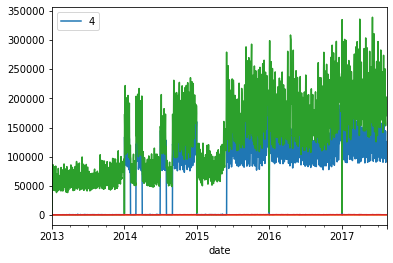

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i, serie_id in enumerate(series_ids):
    prepared_data[prepared_data.family == serie_id].set_index("date").sales.plot(ax=ax)
    ax.legend(f"{i+1}")

<AxesSubplot:xlabel='date'>

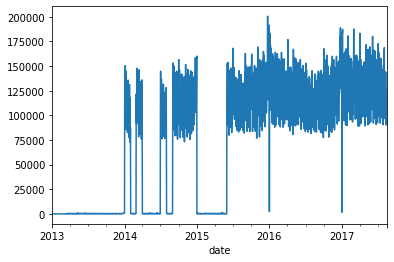

In [77]:
prepared_data[prepared_data.family == series_ids[0]].set_index("date").sales.plot()

<AxesSubplot:xlabel='date'>

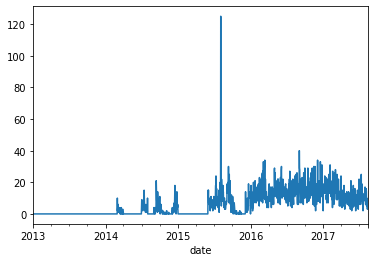

In [78]:
prepared_data[prepared_data.family == series_ids[1]].set_index("date").sales.plot()

<AxesSubplot:xlabel='date'>

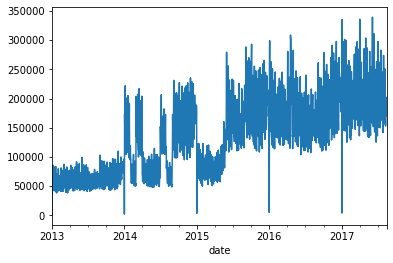

In [79]:
prepared_data[prepared_data.family == series_ids[2]].set_index("date").sales.plot()

<AxesSubplot:xlabel='date'>

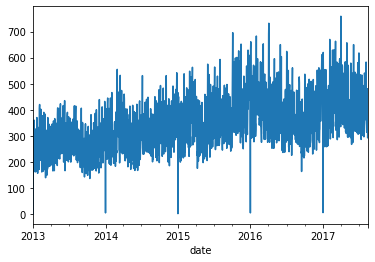

In [80]:
prepared_data[prepared_data.family == series_ids[3]].set_index("date").sales.plot()

# ACF

In [5]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd

In [6]:
def get_acf(series_data):
    ts = series_data.set_index("date").sales
    acf_results = (acf(ts, nlags=360)*-1).argsort()[1:]
    lags = {}
    for i in range(3):
        lags[f"{i+1}_acf"] = acf_results[i] + 1
    return pd.Series(lags)
        
acfs = train.groupby(["store_nbr", "family", "group"]).apply(lambda series_data: get_acf(series_data))

In [7]:
acf

<function statsmodels.tsa.stattools.acf(x, adjusted=False, nlags=None, qstat=False, fft=None, alpha=None, missing='none')>

In [8]:
acfs["1_acf"].value_counts()

2     11
8      3
15     3
29     2
6      1
Name: 1_acf, dtype: int64

In [9]:
acfs["2_acf"].value_counts()

8     6
3     5
15    3
64    2
2     1
4     1
37    1
7     1
Name: 2_acf, dtype: int64

In [10]:
acfs["3_acf"].value_counts()

8     5
15    3
3     2
4     2
22    2
92    2
29    2
2     1
14    1
Name: 3_acf, dtype: int64

## Group 1

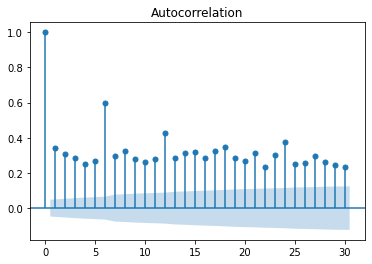

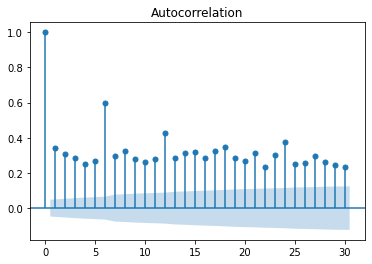

In [29]:
series_group = train[train.group == 1].serie_id.unique()
serie = np.random.choice(series_group)
ts = train[train.serie_id == serie].set_index("date").sales
plot_acf(ts, lags=30)

In [35]:
(acf(ts, nlags=30)*-1).argsort()

array([ 0,  6, 12, 24, 18,  1,  8, 17, 15, 21, 14,  2, 23, 27,  7,  3, 13,
       19, 16, 11,  9, 20,  5, 28, 10, 26, 25,  4, 29, 30, 22])

## Group 2

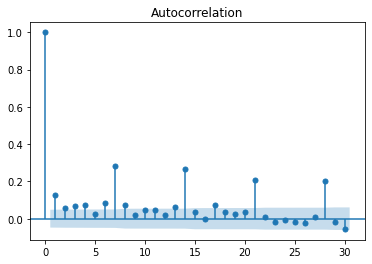

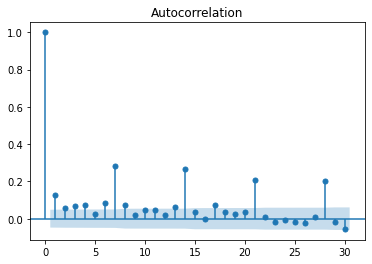

In [26]:
series_group = train[train.group == 2].serie_id.unique()
serie = np.random.choice(series_group)
ts = train[train.serie_id == serie].set_index("date").sales
plot_acf(ts, lags=30)

## Group 3

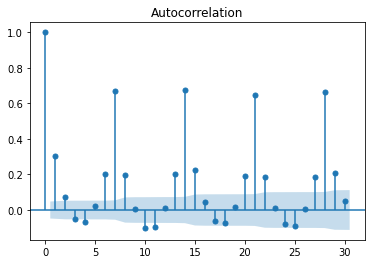

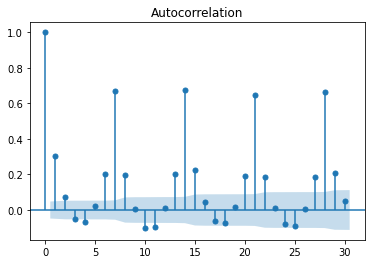

In [27]:
series_group = train[train.group == 3].serie_id.unique()
serie = np.random.choice(series_group)
ts = train[train.serie_id == serie].set_index("date").sales
plot_acf(ts, lags=30)

## Group 4

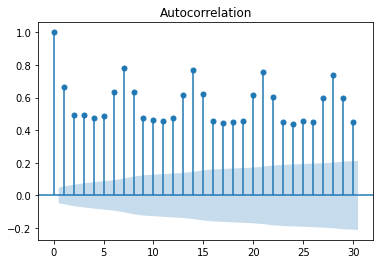

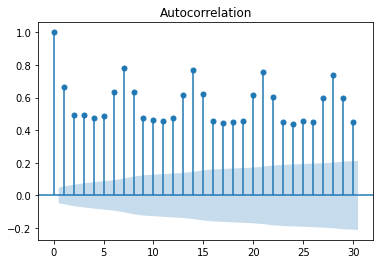

In [28]:
series_group = train[train.group == 4].serie_id.unique()
serie = np.random.choice(series_group)
ts = train[train.serie_id == serie].set_index("date").sales
plot_acf(ts, lags=30)